# Generate SIFT feature vectors for defect classification

This notebook generates feature vectors to be used for clustering local patterns in Rayleigh-Benard Convection. We run the SIFT-like algorithm for the topological and persistent homology keypoints to generate feature vectors at each keypoint.

In [67]:
import numpy as np
import scipy
from scipy.cluster import hierarchy as hc
import pandas as pd
from skimage import morphology
from scipy import misc
from matplotlib import pyplot as plt
import math, time
from skimage import measure
from scipy import signal
from scipy.ndimage.filters import gaussian_filter
from PIL import Image
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn.apionly as sns 

%matplotlib inline  

## Set up local environment variables

In [2]:
sDir = '/Users/birdbrain/Documents/Research/Projects/Schatz/Data/g21chaotic/r4000_2016_11_01_superfast/g21flow'
centerx = 210 # Center-x of circular crop
centery = 210 # Center-y of circular crop
roll_width = 20 # Width of a single roll
crop_radius = 195-roll_width # Radius of circular crop
sOrientation = 'orientation_field_0_5/%06d.bmp'
sPatternData = 'pattern_data/%06d_matches.csv'
sSingularPoints = 'singular_points_0_5/%06d.txt'
sBmp = 'bmps/%06d.bmp'

## Set up variables for generating the feature vectors

In [3]:
radius = roll_width

## Utility functions

In [4]:
def loadData(idx):
    # Get orientation field
    of = misc.imread(sDir + "/" + (sOrientation % idx))
    
    bmp = misc.imread(sDir + "/" + (sBmp % idx))
    
    # Persistent homology defects: pinch=1, h1=2
    ph_features = pd.read_csv(sDir + "/" + (sPatternData % idx))

    # Generate persistent homology defect matrix
    ph_pinches = ph_features.loc[(ph_features['match_type']=='pinch_upper') | (ph_features['match_type']=='pinch_lower')][['center_x','center_y']]
    ph_pinches = ph_pinches.astype(np.int)
    ph_pinches['ph_0'] = 1
    ph_pinches['ph_1'] = 0
    ph_pinches['td_p1'] = 0
    ph_pinches['td_m1'] = 0
    ph_pinches['td_p2'] = 0
    ph_pinches['td_m2'] = 0

    ph_h1 = ph_features.loc[(ph_features['match_type']=='ring_other') | (ph_features['match_type']=='ring_upper') | (ph_features['match_type']=='ring_lower') | (ph_features['match_type']=='plume_other') | (ph_features['match_type']=='plume_upper') | (ph_features['match_type']=='plume_lower')][['center_x','center_y']]
    ph_h1 = ph_h1.astype(np.int)
    ph_h1['ph_0'] = 0
    ph_h1['ph_1'] = 1
    ph_h1['td_p1'] = 0
    ph_h1['td_m1'] = 0
    ph_h1['td_p2'] = 0
    ph_h1['td_m2'] = 0

    ph_defects = np.concatenate((ph_pinches, ph_h1), axis=0)

    # Topological defects
    td = pd.read_csv(sDir + "/" + (sSingularPoints % idx), sep=' ', names=['y', 'x', 'type'])
    td_defects = td.astype(np.int)
    td_defects['ph_0'] = 0
    td_defects['ph_1'] = 0
    td_defects['td_p1'] = (td_defects['type'] == 1).astype(np.int)
    td_defects['td_m1'] = (td_defects['type'] == -1).astype(np.int)
    td_defects['td_p2'] = (td_defects['type'] == 2).astype(np.int)
    td_defects['td_m2'] = (td_defects['type'] == -2).astype(np.int)
    
    td_defects = td_defects.drop('type', 1)
    td_defects = td_defects[['x', 'y', 'ph_0', 'ph_1', 'td_p1', 'td_m1', 'td_p2', 'td_m2']]

    return (of, np.concatenate((ph_defects, td_defects), axis=0), bmp)


In [5]:
def assignOrientations(_keypoints, radius, orientationfield, nbins):
    """
    Takes in the list of keypoints, the orientation field, and the number of binning values to
    use for the orientation field. Generates a histogram of orientations. Computes the max peak.
    Assigns corresponding orientation to the original keypoint. Adds copies of keypoint to the
    table with orientations given by other peaks that are at least 80% of max peak.
    """
    
    allKeypoints = _keypoints
    allKeypoints = np.hstack([allKeypoints, np.zeros((_keypoints.shape[0],2), np.int)])
        
    # Get circular crop
    crop = np.zeros((radius*2, radius*2))
    crop[radius, radius] = 1
    crop = morphology.binary_dilation(crop, morphology.disk(radius))
    
    for i in range(keypoints.shape[0]):
                
        x = keypoints[i,0]
        y = keypoints[i,1]
        
        if (((x - centerx)**2 + (y - centery)**2) <= crop_radius**2):

            # Crop orientation field
            cropped_orientation = orientationfield[(y-radius):(y+radius), (x-radius):(x+radius)]
            
            # Get histogram for the orientation field
            hist = np.histogram(cropped_orientation[crop==1], bins=nbins, range=(0,256))[0]

            # Smooth the histogram slightly
            hist = gaussian_filter(hist, sigma=0.5)
            maxpeak = max(hist)

            peaks = (hist >= 0.8*float(maxpeak)).astype(np.int)
            peak_components = measure.label(peaks, background=0)+1

            maxorientations = []

            for peak_ind in range(1,max(peak_components)+1):
                peak_values = np.multiply((peak_components == peak_ind).astype(int), hist)
                maxorientations.append([np.argmax(peak_values), max(peak_values)])

            maxorientations = np.asarray(maxorientations)

            for j in range(maxorientations.shape[0]):
                if j == 0:
                    allKeypoints[i,-2:] = maxorientations[0,:]
                else:
                    feature = np.concatenate((_keypoints[i,:], maxorientations[j,:]),axis=0)
                    np.vstack([allKeypoints, feature])

    return allKeypoints


In [35]:
def getFeatureVector(orientationfield, rotation, x, y, radius, nbins):
    """
    Takes in a single local patch from the orientation field and generates keypoint descriptor from it.
    Circular patch of given radius centered at (x,y) is cropped from orientation field and divided
    into eight localized patches, after rotating (in degrees) so that the keypoint orientation is 
    centered at zero.
    
    Each smaller patch gets an orientation histogram with the supplied number
    of bins. The value in each bin is the output feature vector for that localized patch, and each of the
    eight localized patches are concatenated together to form a feature vector of length 4*bins.
    
    The eight localized patches are concentric quadrants of two circles at an outer radius of radius and
    an inner radius of radius*(0.66).
    """
    
    inner_radius = int(radius*0.66)
    outer_radius = radius
    
    # INNER CIRCLE
    # Get circular crop
    crop = np.zeros((inner_radius*2, inner_radius*2))
    crop[inner_radius, inner_radius] = 1
    crop = morphology.binary_dilation(crop, morphology.disk(inner_radius))
    
    # Crop orientation field
    cropped_orientation = orientationfield[(y-inner_radius):(y+inner_radius), (x-inner_radius):(x+inner_radius)]
    
    # Rotate cropped orientation field: scale to 180 degrees, subtract rotation, then scale to 255
    rotated_orientation = ((cropped_orientation.astype(np.float)*(180./255.) + float(rotation))*(255./180.)).astype(np.int)%256

    # Get histogram for each of the four inner subregions
    tmp_radius = inner_radius
    hist11_inner = np.histogram(rotated_orientation[0:tmp_radius, 0:tmp_radius][crop[0:tmp_radius, 0:tmp_radius]], bins=nbins, range=(0,256))[0]
    hist12_inner = np.histogram(rotated_orientation[0:tmp_radius, (tmp_radius+1):(2*tmp_radius)][crop[0:tmp_radius, (tmp_radius+1):(2*tmp_radius)]], bins=nbins, range=(0,256))[0]
    hist21_inner = np.histogram(rotated_orientation[(tmp_radius+1):(2*tmp_radius), 0:tmp_radius][crop[(tmp_radius+1):(2*tmp_radius), 0:tmp_radius]], bins=nbins, range=(0,256))[0]
    hist22_inner = np.histogram(rotated_orientation[(tmp_radius+1):(2*tmp_radius), (tmp_radius+1):(2*tmp_radius)][crop[(tmp_radius+1):(2*tmp_radius), (tmp_radius+1):(2*tmp_radius)]], bins=nbins, range=(0,256))[0]
    
    # OUTER CIRCLE
    # Get circular crop
    crop = np.zeros((outer_radius*2, outer_radius*2))
    crop[outer_radius, outer_radius] = 1
    crop = morphology.binary_dilation(crop, morphology.disk(outer_radius))
    remove = np.zeros((outer_radius*2, outer_radius*2))
    remove[outer_radius, outer_radius] = 1
    remove = morphology.binary_dilation(remove, morphology.disk(inner_radius))
    crop = crop ^ remove
    
    # Crop orientation field
    cropped_orientation = orientationfield[(y-outer_radius):(y+outer_radius), (x-outer_radius):(x+outer_radius)]
    
    # Rotate cropped orientation field
    rotated_orientation = ((cropped_orientation.astype(np.float)*(180./255.) + float(rotation))*(255./180.)).astype(np.int)%256

    
    # Get histogram for each of the four outer subregions
    tmp_radius = outer_radius
    hist11_outer = np.histogram(rotated_orientation[0:tmp_radius, 0:tmp_radius][crop[0:tmp_radius, 0:tmp_radius]], bins=nbins, range=(0,256))[0]
    hist12_outer = np.histogram(rotated_orientation[0:tmp_radius, (tmp_radius+1):(2*tmp_radius)][crop[0:tmp_radius, (tmp_radius+1):(2*tmp_radius)]], bins=nbins, range=(0,256))[0]
    hist21_outer = np.histogram(rotated_orientation[(tmp_radius+1):(2*tmp_radius), 0:tmp_radius][crop[(tmp_radius+1):(2*tmp_radius), 0:tmp_radius]], bins=nbins, range=(0,256))[0]
    hist22_outer = np.histogram(rotated_orientation[(tmp_radius+1):(2*tmp_radius), (tmp_radius+1):(2*tmp_radius)][crop[(tmp_radius+1):(2*tmp_radius), (tmp_radius+1):(2*tmp_radius)]], bins=nbins, range=(0,256))[0]
    
    
    # Return feature vector
    featurevector = np.concatenate((hist11_inner, hist12_inner, hist21_inner, hist22_inner, hist11_outer, hist12_outer, hist21_outer, hist22_outer), axis=0)

    return featurevector
    

## Get the feature vectors

In [36]:
for idx in range(1000,1050,50):

    of, keypoints, bmp = loadData(idx)

    # Generate additional keypoints based on orientation fields.
    allkeypoints = assignOrientations(keypoints, radius, of, 18)

    allFeatures = []

    # Loop through all topological and p.h. defects and generate feature vectors
    for i in range(keypoints.shape[0]):

        x = keypoints[i,0]
        y = keypoints[i,1]
        
        orientation = allkeypoints[i,8]
        rotation = -orientation*10

        # Only process points within tolerance of boundary
        if (((x - centerx)**2 + (y - centery)**2) <= crop_radius**2):
            features = np.concatenate((allkeypoints[i], [bmp[y, x]], getFeatureVector(of, rotation, x, y, radius/2, 8)),axis=0)
            if len(allFeatures) == 0:
                allFeatures = features
            else:
                allFeatures = np.vstack([allFeatures, features])

    # Save feature vectors to file
    np.savetxt(sDir + '/' + ('feature_vectors/%06d.txt' % idx),allFeatures,fmt='%d',delimiter=' ')

In [10]:
idx = 1000

nbins_local = 8

of, keypoints, bmp = loadData(idx)

# Generate additional keypoints based on orientation fields.
allkeypoints = assignOrientations(keypoints, radius, of, 18)

allFeatures = []

# Loop through all topological and p.h. defects and generate feature vectors
for i in range(keypoints.shape[0]):

    x = keypoints[i,0]
    y = keypoints[i,1]
    
    orientation = allkeypoints[i,8]
    rotation = -orientation*10

    # Only process points within tolerance of boundary
    if (((x - centerx)**2 + (y - centery)**2) <= crop_radius**2):
        features = np.concatenate((allkeypoints[i], [bmp[y,x]], getFeatureVector(of, rotation, x, y, radius/2, nbins_local)),axis=0)
        if len(allFeatures) == 0:
            allFeatures = features
        else:
            allFeatures = np.vstack([allFeatures, features])


/Users/birdbrain/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


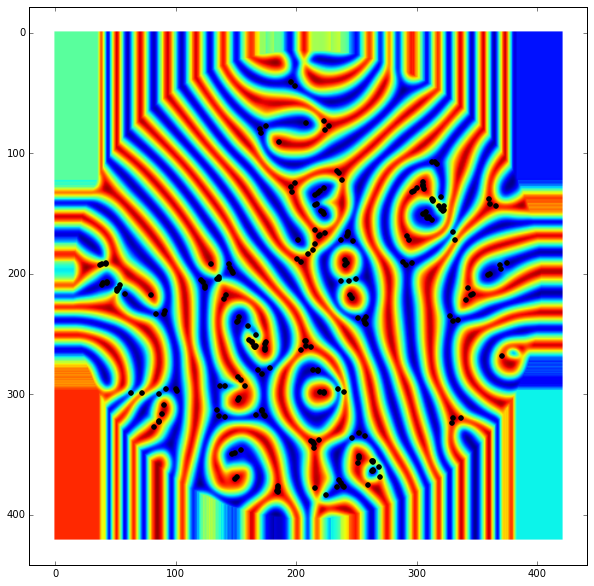

In [11]:
plt.figure(figsize=(10,10))
plt.imshow(bmp)
plt.scatter(allFeatures[:,0], allFeatures[:,1], color='black')

In [19]:
tmp_radius = radius

key = allFeatures[10,:]
 
orientation = key[8]
rotation = -orientation*10

key_bmp = bmp[(key[1]-tmp_radius):(key[1]+tmp_radius), (key[0]-tmp_radius):(key[0]+tmp_radius)]
key_of = of[(key[1]-tmp_radius):(key[1]+tmp_radius), (key[0]-tmp_radius):(key[0]+tmp_radius)]

print key
print orientation, rotation

[136 204   1   0   0   0   0   0   6 154  86   5   8   5   4   0   0   0
   0   5   0   0   0   9   3   2   3   0   0   0  10   7   2   1   2   2
  12   7   1   0   0   0   0  29   3   2   3  10   0   0   0  14   0   0
   0  25   4   2   2   5   0   0   2  33   2   2   3  29   4   4   5   5
   0   0   0]
6 -60


array([136, 204,   1,   0,   0,   0,   0,   0,   6, 154,  86,   5,   8,
         5,   4,   0,   0,   0,   0,   5,   0,   0,   0,   9,   3,   2,
         3,   0,   0,   0,  10,   7,   2,   1,   2,   2,  12,   7,   1,
         0,   0,   0,   0,  29,   3,   2,   3,  10,   0,   0,   0,  14,
         0,   0,   0,  25,   4,   2,   2,   5,   0,   0,   2,  33,   2,
         2,   3,  29,   4,   4,   5,   5,   0,   0,   0])

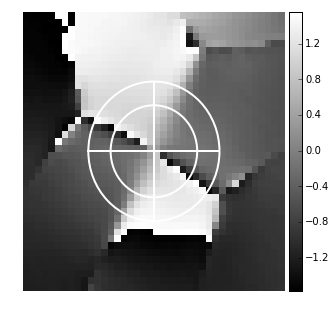

In [63]:
transform_key_of = (math.pi*key_of/255.)-math.pi/2.

plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.figure()
ax = plt.gca()
plt.set_cmap('gray')
plt.gca().set_axis_off()
# im = ax.pcolor(key_bmp);
im = ax.pcolor(transform_key_of);

plt.plot([tmp_radius - tmp_radius/2., tmp_radius + tmp_radius/2.], [tmp_radius, tmp_radius], color='white', lw=2)
plt.plot([tmp_radius, tmp_radius], [tmp_radius - tmp_radius/2., tmp_radius + tmp_radius/2.], color='white', lw=2)

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

circle1 = plt.Circle((tmp_radius, tmp_radius), tmp_radius/2., color='white', fill=False, lw=2)
ax.add_artist(circle1)

circle2 = plt.Circle((tmp_radius, tmp_radius), 0.66*tmp_radius/2., color='white', fill=False, lw=2)
ax.add_artist(circle2)


plt.scatter(tmp_radius, tmp_radius, color='black')



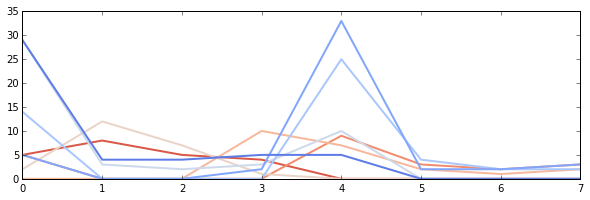

In [69]:

plt.rcParams['figure.figsize'] = (10.0, 3.0)
fig = plt.gcf()
ax = plt.gca()
ax.set_color_cycle(sns.color_palette("coolwarm_r",8))
plt.plot(np.reshape(key[11:], (8,nbins_local)).T, lw=2);



In [29]:
inner_radius = int(radius*0.66)
outer_radius = radius
orientationfield = of
nbins = 8

x = key[0]
y = key[1]

orientation = key[8]
rotation = -orientation*10

print rotation

# INNER CIRCLE
# Get circular crop
crop = np.zeros((inner_radius*2, inner_radius*2))
crop[inner_radius, inner_radius] = 1
crop = morphology.binary_dilation(crop, morphology.disk(inner_radius))

# Crop orientation field
cropped_orientation = orientationfield[(y-inner_radius):(y+inner_radius), (x-inner_radius):(x+inner_radius)]


# Rotate cropped orientation field
rotated_orientation = ((cropped_orientation.astype(np.float)*(180./255.) + float(rotation))*(255./180.)).astype(np.int)%255



-60
336
336


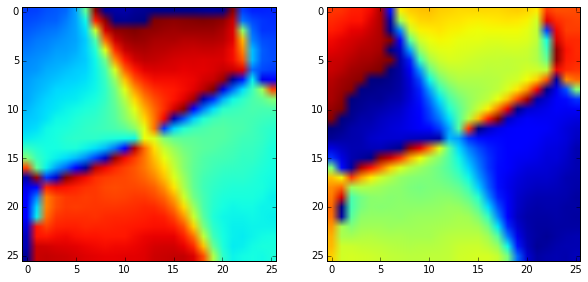

In [22]:
plt.subplot(1,2,1)
plt.imshow(cropped_orientation);
plt.subplot(1,2,2)
plt.imshow(rotated_orientation);

[165 260   1   0   0   0   0   0]


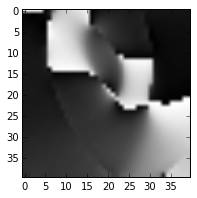

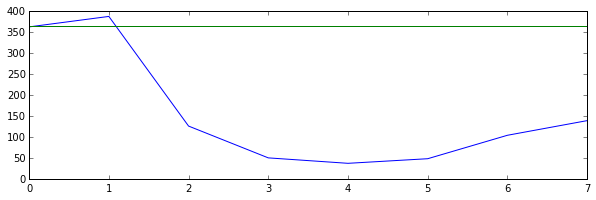

In [95]:
idx = 1000

nbins_local = 8

of, keypoints, bmp = loadData(idx)

key = keypoints[4,:]
print key

# Get circular crop
crop = np.zeros((radius*2, radius*2))
crop[radius, radius] = 1
crop = morphology.binary_dilation(crop, morphology.disk(radius))

x = key[0]
y = key[1]


# Crop orientation field
cropped_orientation = of[(y-radius):(y+radius), (x-radius):(x+radius)]

plt.figure()
plt.imshow(cropped_orientation)

# Get histogram for the orientation field
hist = np.histogram(cropped_orientation[crop==1], bins=nbins, range=(0,256))[0]

plt.figure()
plt.plot(hist)

# Smooth the histogram slightly
hist = gaussian_filter(hist, sigma=0.5)
maxpeak = max(hist)

plt.plot([0,7], [maxpeak, maxpeak])

peaks = (hist >= 0.8*float(maxpeak)).astype(np.int)
peak_components = measure.label(peaks, background=0)+1
